#### Set up the environment

In [44]:
import requests
import math
import numpy as np
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Get US weather station metadata

In [2]:
file = "data/stations.txt"

with open(file, 'rb') as f:
        list_st = f.readlines()

In [10]:
station_metadata = [i.decode("utf-8") for i in list_st]

In [11]:
station_metadata[20:35]

['USAF   WBAN  STATION NAME                  CTRY ST CALL  LAT     LON      ELEV(M) BEGIN    END\n',
 '\n',
 '007018 99999 WXPOD 7018                                  +00.000 +000.000 +7018.0 20110309 20130730\n',
 '007026 99999 WXPOD 7026                    AF            +00.000 +000.000 +7026.0 20120713 20170822\n',
 '007070 99999 WXPOD 7070                    AF            +00.000 +000.000 +7070.0 20140923 20150926\n',
 '008260 99999 WXPOD8270                                   +00.000 +000.000 +0000.0 20050101 20120731\n',
 '008268 99999 WXPOD8278                     AF            +32.950 +065.567 +1156.7 20100519 20120323\n',
 '008307 99999 WXPOD 8318                    AF            +00.000 +000.000 +8318.0 20100421 20100421\n',
 '008411 99999 XM20                                                                 20160217 20160217\n',
 '008414 99999 XM18                                                                 20160216 20160217\n',
 '008415 99999 XM21                         

In [4]:
from collections import namedtuple

In [6]:
stations_us = [] 
station_i = namedtuple("station", "usaf wban station_code st_name country state call latitude longitude elevation begin end forecastlink")

for i in list_string[22:]:
    if i[43:45] == "US":
        usaf = i[:6].replace(" ", "")
        wban = i[7:12].replace(" ", "")
        station_code = i[13:18].replace(" ", "")
        st_name = i[19:42].replace(" ", "")
        country = i[43:45].replace(" ", "")
        state = i[48:50].replace(" ", "")
        call = i[51:55].replace(" ", "")
        latitude = i[57:64].replace(" ", "").replace("+","")
        longitude = i[65:73].replace(" ", "").replace("+","")
        elevation = i[74:81].replace(" ", "").replace("+","")
        begin = i[82:90].replace(" ", "")
        end = i[91:99].replace(" ", "")
        try:
            forecastlink = requests.get("https://api.weather.gov/points/"+latitude+","+longitude).json()['properties']['forecastGridData']
        except KeyError:
            forecastlink = ""
        stations_us.append(station_i(usaf, wban, station_code, st_name, country, state, call, latitude, longitude, elevation, begin, end, forecastlink))
    else:
        pass

#### Data cleaning: removing certain weather stations (e.g. no coordinates, no forecasts available, etc)

In [7]:
for i in stations_us:
    if i.latitude == "":
        stations_us.remove(i)
    elif i.longitude == "":
        stations_us.remove(i)

In [8]:
for i in stations_us:
    try: 
        if requests.get("https://api.weather.gov/points/"+i.latitude+","+i.longitude).json()["status"] == 404:
            stations_us.remove(i)
    except KeyError:
        pass

In [41]:
for i in stations_us:
    if len(i.latitude) < 1:
        stations_us.remove(i)
    elif len(i.longitude) < 1:
        stations_us.remove(i)
    elif i.usaf == '997957':
        stations_us.remove(i)

#### Checkpoint: export US weather stations into .csv file

In [ ]:
import csv
with open('US_stations.csv', 'w',) as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['usaf', 'wban', 'station_code', 'st_name', 'country', 'state', 'call', 'latitude', 'longitude', 'elevation', 'begin', 'end', 'forecast_api_endpoint'])
    for station in stations_us:
        writer.writerow([station.usaf, station.wban, station.station_code, station.st_name, station.country, station.state, station.call, station.latitude,\
                        station.longitude, station.elevation, station.begin, station.end, station.forecastlink])

#### Build helper functions to organize forecast API output 

In [18]:
def temp_forecast (x):
# api is forecastGridData endpoint e.g. 'https://api.weather.gov/gridpoints/EPZ/106,80'; can be called by stations_us.forecastlink
    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['temperature']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [19]:
def dew_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['dewpoint']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [20]:
def hum_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['relativeHumidity']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [21]:
def wind_d_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['windDirection']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [22]:
def wind_s_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['windSpeed']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [23]:
def wind_g_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['windGust']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [24]:
def prcp_p_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['probabilityOfPrecipitation']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [25]:
def prcp_q_forecast (x):

    api = requests.get(x).json()
    dates = []
    output = []

    for i in api['properties']['quantitativePrecipitation']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates.append(dateobject)
            output.append(forecast)
        else:
            dates.append(dateobject)
            output.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates.append(dateobject)
                output.append(forecast)
                forhowmany -= 1
    
    return dates, output

In [26]:
def tw_forecast (x):
# api is forecastGridData endpoint e.g. 'https://api.weather.gov/gridpoints/EPZ/106,80'; can be called by stations_us.forecastlink
    api = requests.get(x).json()
    dates_t = []
    dates_wd = []
    dates_ws = []
    output_t = []
    output_wd = []
    output_ws = []

    for i in api['properties']['temperature']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates_t.append(dateobject)
            output_t.append(forecast)
        else:
            dates_t.append(dateobject)
            output_t.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_t.append(dateobject)
                output_t.append(forecast)
                forhowmany -= 1
                
    for i in api['properties']['windDirection']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates_wd.append(dateobject)
            output_wd.append(forecast)
        else:
            dates_wd.append(dateobject)
            output_wd.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_wd.append(dateobject)
                output_wd.append(forecast)
                forhowmany -= 1
                
    for i in api['properties']['windSpeed']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates_ws.append(dateobject)
            output_ws.append(forecast)
        else:
            dates_ws.append(dateobject)
            output_ws.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_ws.append(dateobject)
                output_ws.append(forecast)
                forhowmany -= 1
    
    return dates_t, dates_ws, dates_wd, output_t, output_ws, output_wd

In [27]:
def append_value(dict_obj, key, value):
    if key in dict_obj:
        if not isinstance(dict_obj[key], list):
            dict_obj[key] = [dict_obj[key]]
        dict_obj[key].append(value)
    else:
        pass

Below aggregates all parsed forecast data to an object

In [28]:
def generate_forecast(api):
    t1, temp = temp_forecast(api)
    t2, dew = dew_forecast(api)
    t3, hum = hum_forecast(api)
    t4, wd = wind_d_forecast(api)
    t5, ws = wind_s_forecast(api)
    t6, wg = wind_g_forecast(api)
    t7, pp = prcp_p_forecast(api)
    t8, pq = prcp_q_forecast(api)
    
#     output = dict(zip(t1, temp))
    
#     for key, value in dict(zip(t2, dew)):
#         append_value(output, key, value)
    output = [t1, temp] 
    
    if t1 == t2:
        output.append(dew)
        output.append(hum)
        output.append(wd)
        output.append(ws)
        output.append(wg)
        output.append(pp)
        output.append(pq)
        
    return output

Below defines euclidean distance function for finding the neighboring weather stations when one station is queried

In [29]:
def distance_calc(a, b):
    R = 3963
    lat1 = math.radians(float(a.latitude))
    lon1 = math.radians(float(a.longitude))
    lat2 = math.radians(float(b.latitude))
    lon2 = math.radians(float(b.longitude))
    
    lat_d = lat1 - lat2
    lon_d = lon1 - lon2

    p = math.sin(lat_d / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon_d / 2)**2
    c = 2 * math.atan2(math.sqrt(p), math.sqrt(1 - p))
    
    distance = R * c
    
    return distance

In [30]:
distance_calc(stations_us[501], stations_us[600])

974.1962985515023

Below retrieves n-neighbors closest to the input_station

In [31]:
def n_neighbors(input_station, n):
    
    placeholder1 = []
    placeholder2 = []

    for i in stations_us:
        placeholder1.append(i)
        placeholder2.append(distance_calc(input_station,i))

    distances = np.array(placeholder2)
    location_idx = np.argsort(distances)[:n].tolist()

    
############ FIX SCATTER PLOT TO SHOW INDIVIDUALLY ### 
    for i in location_idx:
        try:
            tt, tws, twd, temp, winds, windd = tw_forecast(placeholder1[i].forecastlink)
            sns.scatterplot(tws, winds)
            sns.scatterplot(twd, windd)
            sns.scatterplot(tt, temp)
            print(placeholder1[i])
        except KeyError:
            print("Forecast not available for the station")

Lets see how the parsed API could look like:

In [36]:
tt, tws, twd, temp, winds, windd = tw_forecast(stations_us[525].forecastlink)

<AxesSubplot:>

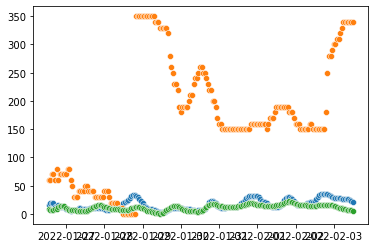

In [39]:
sns.scatterplot(tws, winds)
sns.scatterplot(twd, windd)
sns.scatterplot(tt, temp)
# matplotlib.axes.Axes.quiver

#### Below is another dictionary used to build out visuals of historicals at certain well-known locations

In [14]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite:////Users/nk/Documents/Metis/07 Engineering/Project/data/weather.db")

In [15]:
database_tables = engine.table_names()

In [16]:
database_tables_dict = {}
for i in stations_us: 
    if i.call in database_tables:
        database_tables_dict[i.call] = i

In [ ]:
import pickle 

f = open("select_stations_metadata.pkl","wb")
pickle.dump(database_tables_dict,f)
f.close()